In [23]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt

charging = pd.read_csv("modified_data.csv", encoding = "ISO-8859-1")

In [24]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])

Now Task 2 a.)


For the days, we can't just use the start time because some processes may start at 23:59 and these charging sessions are then falsly attributed to this day, despite the fact that the day is only 1 minute long

In [26]:
#count the percentage of sessions that span multiple days
sessions_spanning_midnight = len(charging[charging['connectionTime'].dt.date != charging['disconnectTime'].dt.date])
percentage_spanning_midnight = (sessions_spanning_midnight / len(charging)) * 100

print(percentage_spanning_midnight)

42.27088036117381


2 approaches for daily: 

1. show every hour
2. divide day in morning, noon ect. and show it by this

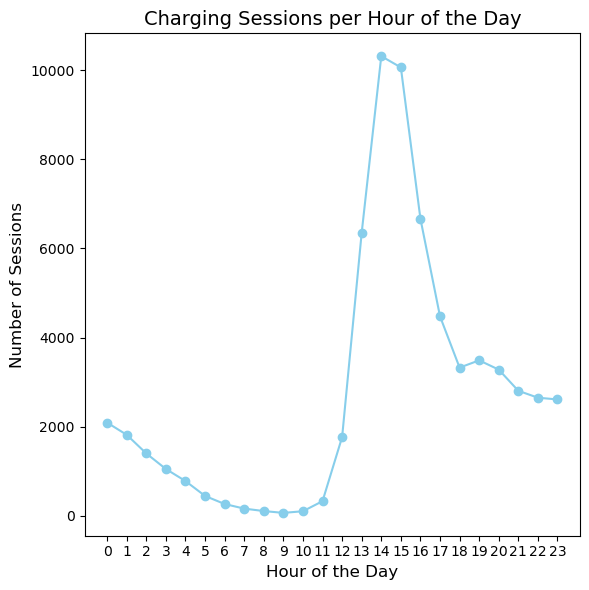

In [45]:
#first approach

charging['hour_of_day'] = charging['connectionTime'].dt.hour

# Count the number of sessions for each hour of the day
sessions_per_hour = charging.groupby('hour_of_day').size()

# Create a line chart for the hourly distribution
plt.figure(figsize=(6, 6))  # Small size for the chart
sessions_per_hour.plot(kind='line', color='skyblue', marker='o')

plt.xticks(range(0, 24))

# Add title and labels
plt.title('Charging Sessions per Hour of the Day', fontsize=14)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

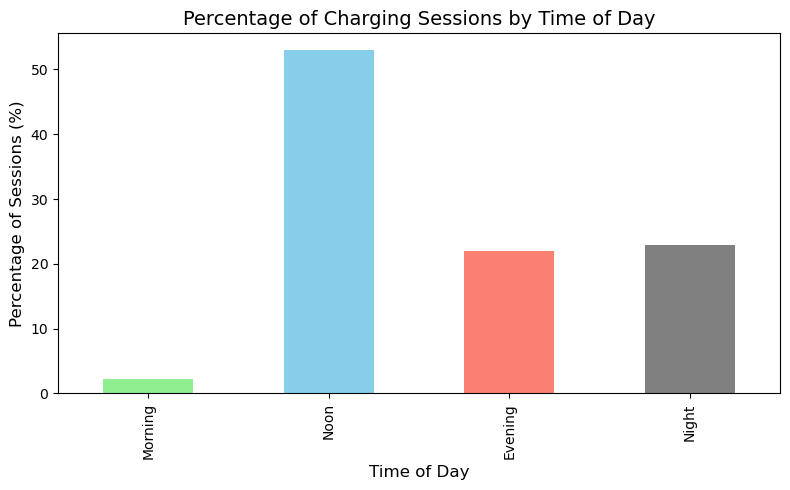

In [46]:
def classify_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Noon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

charging['time_of_day'] = charging['connectionTime'].dt.hour.apply(classify_time_of_day)

# Number of charging sessions for each time of day
time_of_day_counts = charging['time_of_day'].value_counts().reindex(['Morning', 'Noon', 'Evening', 'Night'])

# Calculate percentage of each category
time_of_day_percentage = (time_of_day_counts / time_of_day_counts.sum()) * 100

# create bar chart
plt.figure(figsize=(8, 5))  
time_of_day_percentage.plot(kind='bar', color=['lightgreen', 'skyblue', 'salmon', 'gray'])

plt.title('Percentage of Charging Sessions by Time of Day', fontsize=14)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Percentage of Sessions (%)', fontsize=12)
plt.tight_layout()
plt.show()


We see that there is a pattern in daily use. In the early morning hours the demand is at its lowest and the demand increases as we reach Noon. The peak time is the Noon time around 12pm to 6pm and in the evening from 6pm on the demand decreases linearly until the next day on 10am